In [1]:
#import necessary libraries
import tensorflow as tf
import bayesflow as bf
import numpy as np
import json

/Users/masonyoungblood/anaconda3/envs/bayesflow/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#load in training data and format
with open("train_data.json") as f:
    l = json.load(f)
train_data = {}
train_data["prior_non_batchable_context"] = None
train_data["prior_batchable_context"] = None
train_data["prior_draws"] = np.array(l[0], dtype = float)
train_data["sim_non_batchable_context"] = None
train_data["sim_batchable_context"] = None
train_data["sim_data"] = np.array(l[1], dtype = float)

#load in testing data and format
with open("test_data.json") as f:
    l = json.load(f)
test_data = {}
test_data["prior_non_batchable_context"] = None
test_data["prior_batchable_context"] = None
test_data["prior_draws"] = np.array(l[0], dtype = float)
test_data["sim_non_batchable_context"] = None
test_data["sim_batchable_context"] = None
test_data["sim_data"] = np.array(l[1], dtype = float)

#load in observed data and format
with open("obs_data.json") as f:
    l = json.load(f)
obs_data = {}
obs_data["prior_non_batchable_context"] = None
obs_data["prior_batchable_context"] = None
obs_data["prior_draws"] = None
obs_data["sim_non_batchable_context"] = None
obs_data["sim_batchable_context"] = None
obs_data["sim_data"] = np.array(l, dtype = float)

In [3]:
#set number of parameters, epochs, batch size, and learning rate
num_params = 5
epochs = 500
batch_size = 32
learning_rate = 0.0001

In [5]:
#initialize inference net and amortized posterior with no summary network
#default settings live here: https://github.com/stefanradev93/BayesFlow/blob/master/bayesflow/default_settings.py
summary_net = bf.networks.HierarchicalNetwork(networks_list=[
    bf.networks.DeepSet(summary_dim=256),
    bf.networks.TimeSeriesTransformer(input_dim = 256, num_dense_fc = 2, num_attention_blocks = 2, summary_dim = 32, dense_settings = {"units": 128, "activation": "relu"}, template_type = "gru"),
    tf.keras.Sequential([tf.keras.layers.Dense(32, activation="relu"), 
                         tf.keras.layers.Dropout(0.05),
                         tf.keras.layers.Dense(16)])
])
inference_net = bf.networks.InvertibleNetwork(num_params = 5, num_coupling_layers = num_params, coupling_design = "affine", coupling_settings = {"dropout_prob": 0.05, "num_dense": 2, "dense_args": {"units": 256, "activation": "relu"}})
amortized_posterior = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [6]:
#create trainer
trainer = bf.trainers.Trainer(amortizer = amortized_posterior, default_lr = learning_rate, memory = True, checkpoint_path = "checkpoints")

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized empty simulation memory.
INFO:root:Initialized networks from scratch.


In [7]:
#setup custom optimizer that runs faster on apple silicon
#adapted from _setup_optimizer and train_offline in trainers.py, and defaults in OPTIMIZER_DEFAULTS in default_settings.py
schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs*bf.trainers.SimulationDataset(train_data, batch_size).num_batches, name = "lr_decay")
optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)

In [8]:
#run training and save
history = trainer.train_offline(simulations_dict = train_data, epochs = epochs, batch_size = batch_size, optimizer = optimizer, validation_sims = test_data)
trainer._save_trainer("model")

Training epoch 1: 100%|██████████| 2969/2969 [02:15<00:00, 21.97it/s, Epoch: 1, Batch: 2969,Loss: 4.334,W.Decay: 0.404,Avg.Loss: 4.994,Avg.W.Decay: 0.466,LR: 1.00E-04]
INFO:root:Validation, Epoch: 1, Loss: 3.804
Training epoch 2: 100%|██████████| 2969/2969 [02:03<00:00, 24.13it/s, Epoch: 2, Batch: 2969,Loss: 3.513,W.Decay: 0.329,Avg.Loss: 3.996,Avg.W.Decay: 0.362,LR: 1.00E-04]
INFO:root:Validation, Epoch: 2, Loss: 3.570
Training epoch 3: 100%|██████████| 2969/2969 [01:56<00:00, 25.46it/s, Epoch: 3, Batch: 2969,Loss: 3.718,W.Decay: 0.294,Avg.Loss: 3.727,Avg.W.Decay: 0.310,LR: 1.00E-04]
INFO:root:Validation, Epoch: 3, Loss: 3.399
Training epoch 4: 100%|██████████| 2969/2969 [01:40<00:00, 29.48it/s, Epoch: 4, Batch: 2969,Loss: 1.815,W.Decay: 0.274,Avg.Loss: 3.271,Avg.W.Decay: 0.283,LR: 1.00E-04]
INFO:root:Validation, Epoch: 4, Loss: 2.466
Training epoch 5: 100%|██████████| 2969/2969 [01:48<00:00, 27.30it/s, Epoch: 5, Batch: 2969,Loss: 3.077,W.Decay: 0.259,Avg.Loss: 2.844,Avg.W.Decay: 0.26

In [9]:
#load trained network
trainer.load_pretrained_network()

In [10]:
#sample 100 posterior draws per simulation run in the test set
test_set = trainer.configurator(test_data)
test_posteriors = amortized_posterior.sample(test_set, n_samples = 100)

In [11]:
#save loss curves to files
history["train_losses"].to_csv("training_loss.csv")
history["val_losses"].to_csv("validation_loss.csv")

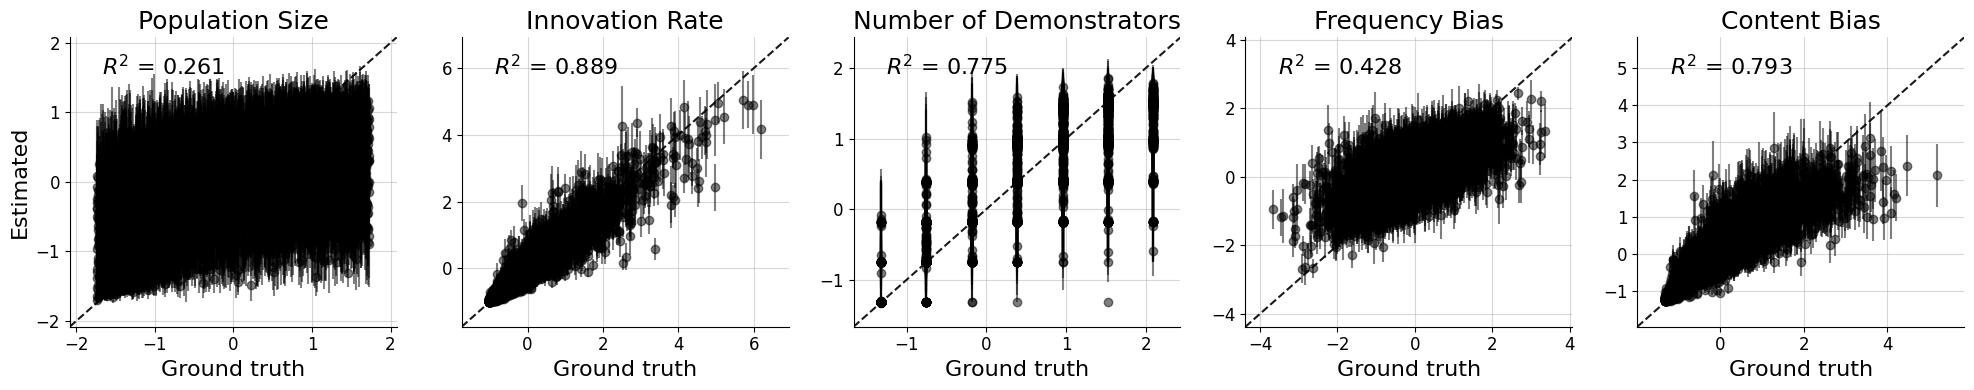

In [12]:
#plot recover of parameter values
recovery_plot = bf.diagnostics.plot_recovery(test_posteriors, test_set["parameters"],
                                             param_names = ["Population Size", "Innovation Rate", "Number of Demonstrators", "Frequency Bias", "Content Bias"], 
                                             color = "black", add_corr = False)
recovery_plot.savefig("recovery_plot.pdf")

In [13]:
#get and save 10000 posterior predictions for each parameter based on the real data
obs_set = trainer.configurator(obs_data)
posterior_predictions = amortized_posterior.sample(obs_set, n_samples = 10000)
with open("posterior_predictions.json", "w") as f:
    json.dump(posterior_predictions.tolist(), f)